In [1]:
import os
import logging
import logging.handlers
import random

import numpy as np
import skvideo.io
import cv2
import matplotlib.pyplot as plt

import utils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cv2.ocl.setUseOpenCL(False)
random.seed(123)

In [3]:
IMAGE_DIR = "./out"
VIDEO_SOURCE = "video/Road traffic video for object recognition(360P).mp4"
SHAPE = (720//2, 1280//2)
EXIT_PTS = np.array([[[732//2, 720//2], [732//2, 590//2], [1280//2, 500//2], [1280//2, 720//2]], [[0//2, 400//2], [645//2, 400//2], [645//2, 0], [0, 0]]])

if not os.path.exists(IMAGE_DIR):
    print("Creating image directory", IMAGE_DIR)
    os.makedirs(IMAGE_DIR)

#creting MOG bg subtractor with 500 frames in cache
#and shadow detction
fgbg = cv2.createBackgroundSubtractorMOG2(history=500, detectShadows=True)

#Set up image source
cap = cv2.VideoCapture('video/short.mp4')

#skipping 500 frames to train bg subtractor
#train_bg_subtractor(bg_subtractor, cap, num=500)

kernel = np.array([[0,1,0],
                   [1,1,1],
                   [0,1,0]],np.uint8)

frame_number = -1
while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    if not frame.any():
        log.error("Frame capture failed, stopping...")
        break

    frame_number += 1

    cv2.imwrite("./out/frame_%04d.png" % frame_number, frame)

    fg_mask = fgbg.apply(frame)
    
    closing = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    dilation = cv2.dilate(opening, kernel, iterations=2)
    ret,thresh = cv2.threshold(dilation,127,255,cv2.THRESH_TOZERO)
    
    cv2.imwrite("./out/fg_mask_%04d.png" % frame_number, thresh)


In [4]:
#fg_mask
fgbg = cv2.createBackgroundSubtractorMOG2()
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

In [ ]:
#code for detection in live video
import numpy as np
import cv2

cap = cv2.VideoCapture('video/short.mp4')

fgbg = cv2.createBackgroundSubtractorMOG2()
#definig kernel for dilation, erosion, etc.
#kernel = np.array([[0,1,0],
#                   [1,1,1],
#                   [0,1,0]],np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))

while(1):
    ret, frame = cap.read()

    fg_mask = fgbg.apply(frame)
    closing = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
    dilation = cv2.dilate(opening, kernel, iterations=2)
    ret,thresh = cv2.threshold(dilation,127,255,cv2.THRESH_TOZERO)

    cv2.imshow('frame1',frame)
    cv2.imshow('frame2',thresh)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

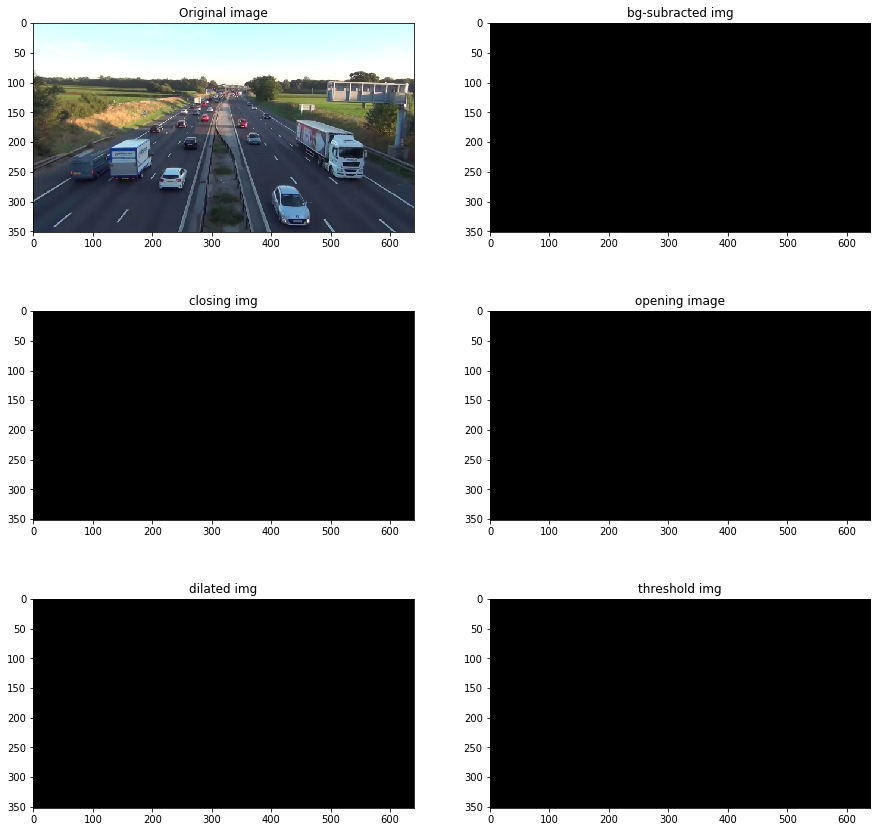

In [5]:
img = cv2.imread("examples/frame_0059.png")
fg_mask = fgbg.apply(img)
closing = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel)
dilation = cv2.dilate(opening, kernel, iterations=2)
ret,thresh = cv2.threshold(dilation,127,255,cv2.THRESH_TOZERO)


new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

f, axs = plt.subplots(3,2,figsize=(15,15))

axs[0,0].imshow(new_img)
axs[0,0].set_title('Original image')
axs[0,1].imshow(fg_mask,'gray')
axs[0,1].set_title('bg-subracted img')
axs[1,0].imshow(closing,'gray')
axs[1,0].set_title('closing img')
axs[1,1].imshow(opening,'gray')
axs[1,1].set_title('opening image')
axs[2,0].imshow(dilation,'gray')
axs[2,0].set_title('dilated img')
axs[2,1].imshow(thresh,'gray')
axs[2,1].set_title('threshold img')

plt.show()

In [6]:
#cv2.imwrite("./examples/fg_mask_0059.png", fg_mask)
#cv2.imwrite("./examples/closing_0059.png", closing)
#cv2.imwrite("./examples/opening_0059.png", opening)
#cv2.imwrite("./examples/dilation_0059.png", dilation)
#cv2.imwrite("./examples/threshold_0059.png", thresh)

In [7]:
from pipeline import (
    PipelineRunner,
    ContourDetection,
    Visualizer,
    CsvWriter,
    VehicleCounter)

In [8]:
def train_bg_subtractor(inst, cap, num=500):
    '''
        BG substractor need process some amount of frames to start giving result
    '''
    print ('Training BG Subtractor...')
    i = 0
    
    for frame in cap:
        inst.apply(frame, None, 0.001)
        i += 1
        if i >= num:
            return cap

In [9]:
if not os.path.exists(IMAGE_DIR):
    print("Creating image directory `%s`...", IMAGE_DIR)
    os.makedirs(IMAGE_DIR)

In [ ]:
# creating exit mask from points, where we will be counting our vehicles
base = np.zeros(SHAPE + (3,), dtype='uint8')
exit_mask = cv2.fillPoly(base, EXIT_PTS, (255, 255, 255))[:, :, 0]

# there is also bgslibrary, that seems to give better BG substruction, but
# not tested it yet
bg_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, detectShadows=True)

# processing pipline for programming conviniance
pipeline = PipelineRunner(pipeline=[
    ContourDetection(bg_subtractor=bg_subtractor,
                     save_image=True, image_dir=IMAGE_DIR),
    # we use y_weight == 2.0 because traffic are moving vertically on video
    # use x_weight == 2.0 for horizontal.
    VehicleCounter(exit_masks=[exit_mask], y_weight=2.0),
    Visualizer(image_dir=IMAGE_DIR),
    CsvWriter(path='./', name='report.csv')
], log_level=logging.DEBUG)

# Set up image source
# You can use also CV2, for some reason it not working for me
cap = skvideo.io.vreader(VIDEO_SOURCE)

# skipping 500 frames to train bg subtractor
train_bg_subtractor(bg_subtractor, cap, num=500)

_frame_number = -1
frame_number = -1
for frame in cap:
    if not frame.any():
        log.error("Frame capture failed, stopping...")
        break

    # real frame number
    _frame_number += 1

    # skip every 2nd frame to speed up processing
    if _frame_number % 2 != 0:
        continue

    # frame number that will be passed to pipline
    # this needed to make video from cutted frames
    frame_number += 1
    #print(frame.shape)
    #plt.imshow(frame)
    #plt.show()
    #break

    pipeline.set_context({
        'frame': frame,
        'frame_number': frame_number,
    })
    pipeline.run()

Training BG Subtractor...
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#


(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(360, 640)
(360, 640, 3)
#
(

In [ ]:
exit_mask

In [ ]:
plt.imshow(exit_mask)

In [ ]:
exit_mask.shape